# Analisis Prediksi Kredit Macet dengan Ensemble Learning
### Workflow Analisis:
1. **Data Loading & Exploration**: Memuat dan eksplorasi dataset NPL
2. **Data Preprocessing**: Feature engineering dan encoding
3. **Oversampling Comparison**: SMOTE vs ADASYN untuk mengatasi imbalanced data
4. **Model Comparison**: Random Forest, XGBoost, LightGBM, Gradient Boosting
5. **Model Evaluation**: Perbandingan performa pada dataset original vs oversampled
6. **Hyperparameter Tuning**: Optimasi model terbaik
7. **Final Model**: Model final dengan performa terbaik

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           f1_score, precision_score, recall_score)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.metrics import classification_report_imbalanced
import subprocess
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.metrics import classification_report_imbalanced

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display, HTML

# SAVE MODEL UNTUK PRODUCTION
import os
import joblib
import json
from pathlib import Path
from datetime import datetime

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

In [9]:
print("Loading Dataset NPL...")
df = pd.read_excel("DataSet NPL.xlsx")

target_counts = df["KETERANGAN"].value_counts()
target_props = df["KETERANGAN"].value_counts(normalize=True) * 100

for kelas, count in target_counts.items():
    prop = target_props[kelas]
    print(f"{kelas:<25}| {count:6d}\t| {prop:6.2f}%")

print(f"\nTotal samples: {len(df)}")
print(f"Number of classes: {df['KETERANGAN'].nunique()}")

# Display dengan tombol download yang lebih menarik
from IPython.display import display, HTML
import base64


# Fungsi untuk membuat download link
def create_download_link(df, title="Download Dataset", filename="dataset_npl.csv"):
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode()).decode()

    button_style = """
    <style>
    .download-btn {
        background-color: #008CBA;
        color: white;
        padding: 12px 24px;
        text-align: center;
        text-decoration: none;
        display: inline-block;
        font-size: 16px;
        margin: 10px 2px;
        cursor: pointer;
        border: none;
        border-radius: 8px;
        transition: background-color 0.3s;
    }
    .download-btn:hover {
        background-color: #005f73;
    }
    </style>
    """

    button_html = f"""
    {button_style}
    <a href="data:file/csv;base64,{b64}" download="{filename}" class="download-btn">
        📊 {title}
    </a>
    """
    return button_html


# Tampilkan tombol dan tabel
display(HTML(create_download_link(df, "Download NPL Dataset")))
print("\nPreview Dataset:")
display(df.head())

Loading Dataset NPL...
Lancar                   |    700	|  46.67%
Dalam Perhatian Khusus   |    400	|  26.67%
Macet                    |    151	|  10.07%
Kurang Lancar            |    134	|   8.93%
Diragukan                |    115	|   7.67%

Total samples: 1500
Number of classes: 5



Preview Dataset:


,NO,PEKERJAAN,KETERANGAN_PEKERJAAN,TANGGAL_LAHIR,STATUS_PERNIKAHAN,KETERANGAN_STATUS_PERNIKAHAN,KELURAHAN,KECAMATAN,KOTA,PROVINSI,...,PLAFOND,JK_WAKTUBULAN,HASIL_PRESCREENING_SLIK,HASIL_PRESCREENING_SIKPKUR,HASIL_PRESCREENING_DUKCAPIL,HASIL_PRESCREENING_DHNBI,HASIL_PRESCREENING_1,STATUS,KOLEKTABILITAS,KETERANGAN
0,1,37,Pegawai pemerintahan/lembaga negara,1978-06-06,K,Kawin,GROGOL UTARA,KEBAYORAN LAMA,JAKARTA SELATAN,DKI JAKARTA,...,141200000.0,60,Low,-,Sesuai,Tidak,Lolos,Accept,1,Lancar
1,2,9,"Pengajar (Guru,Dosen)",1975-04-30,B,Belum Kawin,JURANGMANGU BARAT,PONDOK AREN,TANGERANG SELATAN,BANTEN,...,418000000.0,126,High,-,Sesuai,Tidak,Lolos,Waiting Approval,3,Kurang Lancar
2,3,9,"Pengajar (Guru,Dosen)",1986-03-15,K,Kawin,PULAU PANGGANG,KEPULAUAN SERIBU UTARA,KEPULAUAN SERIBU,DKI JAKARTA,...,265500000.0,192,Low,-,Sesuai,Tidak,Lolos,Accept,1,Lancar
3,4,37,Pegawai pemerintahan/lembaga negara,1971-09-12,K,Kawin,JOGLO,KEMBANGAN,JAKARTA BARAT,DKI JAKARTA,...,305000000.0,109,Low,-,Sesuai,Tidak,Lolos,Accept,1,Lancar
4,5,37,Pegawai pemerintahan/lembaga negara,1976-09-23,K,Kawin,KELAPA GADING TIMUR,KELAPA GADING,JAKARTA UTARA,DKI JAKARTA,...,91000000.0,60,High,-,Sesuai,Tidak,Lolos,Waiting Approval,3,Kurang Lancar


## 📊 1. Data Exploration dan Preprocessing

In [10]:
def preprocess_data(df):
    df_processed = df.copy()
    df_processed.drop(
        columns=[
            "NO",
            "KETERANGAN_PEKERJAAN",
            "KETERANGAN_SUB_PRODUK",
            "TANGGAL_LAHIR",
            "KETERANGAN_STATUS_PERNIKAHAN",
            "KELURAHAN",
            "KECAMATAN",
            "KOTA",
            "PROVINSI",
            "TANGGAL_INPUT",
            "KETERANGAN",
        ],
        inplace=True,
        errors="ignore",
    )
    categorical_cols = [
        "STATUS_PERNIKAHAN",
        "PRODUK",
        "SUB_PRODUK",
        "HASIL_PRESCREENING_SLIK",
        "HASIL_PRESCREENING_SIKPKUR",
        "HASIL_PRESCREENING_DUKCAPIL",
        "HASIL_PRESCREENING_DHNBI",
        "HASIL_PRESCREENING_1",
        "STATUS",
    ]
    label_encoders = {}
    for col in categorical_cols:
        if col in df_processed.columns:
            le = LabelEncoder()
            df_processed[f"{col}"] = le.fit_transform(df_processed[col].astype(str))
            label_encoders[col] = le
    return df_processed, label_encoders


df_processed, label_encoders = preprocess_data(df)

print(f"FINAL PROCESSED DATASET SHAPE: {df_processed.shape}")
print(f"Original features: {len(df_processed.columns)}")
print("HASIL PREPROCESSING DATA - PROCESSED DATASET")
print("=" * 100)

# Fungsi untuk multiple download buttons
from IPython.display import display, HTML
import base64


def create_download_buttons(original_df, processed_df):
    # Original dataset
    csv_original = original_df.to_csv(index=False)
    b64_original = base64.b64encode(csv_original.encode()).decode()

    # Processed dataset
    csv_processed = processed_df.to_csv(index=False)
    b64_processed = base64.b64encode(csv_processed.encode()).decode()

    buttons_html = f"""
    <style>
    .download-btn {{
        color: white;
        padding: 10px 20px;
        text-align: center;
        text-decoration: none;
        display: inline-block;
        font-size: 14px;
        margin: 5px;
        cursor: pointer;
        border: none;
        border-radius: 6px;
        transition: background-color 0.3s;
    }}
    .btn-original {{
        background-color: #007bff;
    }}
    .btn-original:hover {{
        background-color: #0056b3;
    }}
    .btn-processed {{
        background-color: #28a745;
    }}
    .btn-processed:hover {{
        background-color: #1e7e34;
    }}
    </style>
    
    <div>
        <a href="data:file/csv;base64,{b64_original}" download="original_dataset_npl.csv" class="download-btn btn-original">
            📁 Original Dataset ({original_df.shape[0]}×{original_df.shape[1]})
        </a>
        <a href="data:file/csv;base64,{b64_processed}" download="processed_dataset_npl.csv" class="download-btn btn-processed">
            🔧 Processed Dataset ({processed_df.shape[0]}×{processed_df.shape[1]})
        </a>
    </div>
    """
    return buttons_html


# Tampilkan informasi perbandingan
print("\n📊 Dataset Comparison:")
print(f"Original:  {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Processed: {df_processed.shape[0]} rows × {df_processed.shape[1]} columns")
print(f"Columns removed: {df.shape[1] - df_processed.shape[1]}")

# Tampilkan tombol download
display(HTML(create_download_buttons(df, df_processed)))

# Tampilkan preview
print("\nPreview Processed Dataset:")
display(df_processed.head())

FINAL PROCESSED DATASET SHAPE: (1500, 13)
Original features: 13
HASIL PREPROCESSING DATA - PROCESSED DATASET

📊 Dataset Comparison:
Original:  1500 rows × 24 columns
Processed: 1500 rows × 13 columns
Columns removed: 11



Preview Processed Dataset:


,PEKERJAAN,STATUS_PERNIKAHAN,PRODUK,SUB_PRODUK,PLAFOND,JK_WAKTUBULAN,HASIL_PRESCREENING_SLIK,HASIL_PRESCREENING_SIKPKUR,HASIL_PRESCREENING_DUKCAPIL,HASIL_PRESCREENING_DHNBI,HASIL_PRESCREENING_1,STATUS,KOLEKTABILITAS
0,37,2,0,0,141200000.0,60,1,0,0,0,0,0,1
1,9,0,0,0,418000000.0,126,0,0,0,0,0,3,3
2,9,2,0,0,265500000.0,192,1,0,0,0,0,0,1
3,37,2,0,0,305000000.0,109,1,0,0,0,0,0,1
4,37,2,0,0,91000000.0,60,0,0,0,0,0,3,3


In [4]:
def prepare_model_features(df_processed):
    feature_columns = [
        'PEKERJAAN', 'PLAFOND', 'JK_WAKTUBULAN',
        'STATUS_PERNIKAHAN', 'PRODUK','SUB_PRODUK',
        'HASIL_PRESCREENING_SLIK', 'HASIL_PRESCREENING_SIKPKUR',
        'HASIL_PRESCREENING_DUKCAPIL', 'HASIL_PRESCREENING_DHNBI',
        'HASIL_PRESCREENING_1', 'STATUS'
    ]
    available_features = [col for col in feature_columns if col in df_processed.columns]
    X = df_processed[available_features].copy()
    y = df_processed['KOLEKTABILITAS'].copy()
    X = X.fillna(X.median())
    return X, y, available_features
X, y, feature_names = prepare_model_features(df_processed)

print(f"\n📊 Final Dataset Information:")
print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print(f"Number of features: {len(feature_names)}")

print(f"\n🏷️  Feature List:")
for i, feature in enumerate(feature_names, 1):
    print(f"{i:2d}. {feature}")

print(f"\n🎯 Target Distribution:")
target_dist = y.value_counts()
display(target_dist)

# Calculate class imbalance ratio
imbalance_ratio = target_dist.max() / target_dist.min()
print(f"\n⚖️  Class Imbalance Ratio: {imbalance_ratio:.2f}")
print(f"📈 Majority class: {target_dist.index[0]} ({target_dist.iloc[0]} samples)")
print(f"📉 Minority class: {target_dist.index[-1]} ({target_dist.iloc[-1]} samples)")




📊 Final Dataset Information:
Features (X) shape: (1500, 12)
Target (y) shape: (1500,)
Number of features: 12

🏷️  Feature List:
 1. PEKERJAAN
 2. PLAFOND
 3. JK_WAKTUBULAN
 4. STATUS_PERNIKAHAN
 5. PRODUK
 6. SUB_PRODUK
 7. HASIL_PRESCREENING_SLIK
 8. HASIL_PRESCREENING_SIKPKUR
 9. HASIL_PRESCREENING_DUKCAPIL
10. HASIL_PRESCREENING_DHNBI
11. HASIL_PRESCREENING_1
12. STATUS

🎯 Target Distribution:


KOLEKTABILITAS
1    700
2    400
5    151
3    134
4    115
Name: count, dtype: int64


⚖️  Class Imbalance Ratio: 6.09
📈 Majority class: 1 (700 samples)
📉 Minority class: 4 (115 samples)


## 📈 2. Exploratory Data Analysis (EDA)

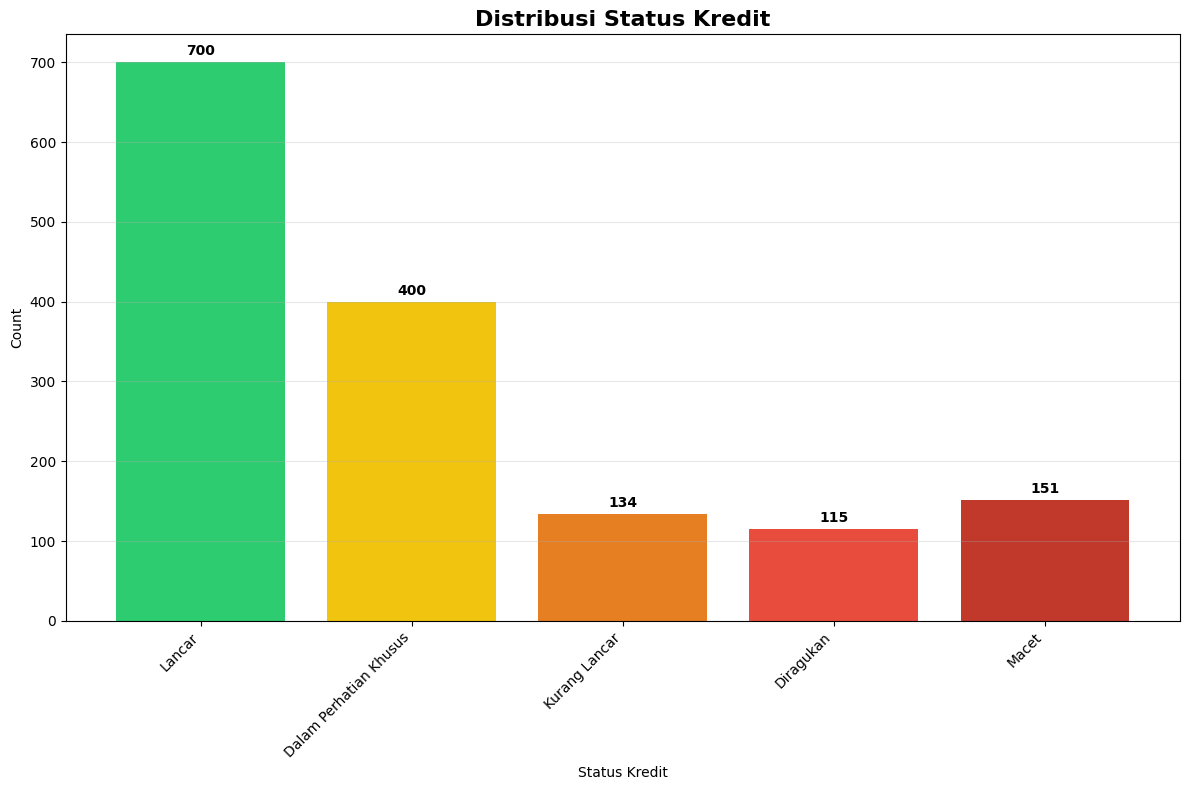

In [5]:
plt.figure(figsize=(12, 8))
target_counts = y.value_counts().sort_index()

labels = {
    1: "Lancar",
    2: "Dalam Perhatian Khusus",
    3: "Kurang Lancar",
    4: "Diragukan",
    5: "Macet",
}

colors = ["#2ecc71", "#f1c40f", "#e67e22", "#e74c3c", "#c0392b"]
x_positions = range(len(target_counts))
bars = plt.bar(x_positions, target_counts.values, color=colors)
plt.title("Distribusi Status Kredit", fontsize=16, fontweight="bold")
plt.xlabel("Status Kredit")
plt.ylabel("Count")
plt.xticks(
    x_positions, [labels[i] for i in target_counts.index], rotation=45, ha="right"
)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 5,
        f"{int(height)}",
        ha="center",
        va="bottom",
        fontweight="bold",
    )
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

## ⚖️ 3. Oversampling Techniques Comparison

Original train set distribution:


KOLEKTABILITAS
1    560
2    320
5    121
3    107
4     92
Name: count, dtype: int64

Train set shape: (1200, 12)
Test set shape: (300, 12)
Oversampling Results (80:20 Ratio):

Original Dataset:
Shape: (1200, 12)
Class distribution:
  Class 1:  560 samples ( 46.7%)
  Class 2:  320 samples ( 26.7%)
  Class 3:  107 samples (  8.9%)
  Class 4:   92 samples (  7.7%)
  Class 5:  121 samples ( 10.1%)
  Balance Ratio (Max/Min): 6.09

SMOTE (80:20) Dataset:
Shape: (2352, 12)
Class distribution:
  Class 1:  560 samples ( 23.8%)
  Class 2:  448 samples ( 19.0%)
  Class 3:  448 samples ( 19.0%)
  Class 4:  448 samples ( 19.0%)
  Class 5:  448 samples ( 19.0%)
  Balance Ratio (Max/Min): 1.25

ADASYN (80:20) Dataset:
Shape: (2331, 12)
Class distribution:
  Class 1:  560 samples ( 24.0%)
  Class 2:  448 samples ( 19.2%)
  Class 3:  443 samples ( 19.0%)
  Class 4:  453 samples ( 19.4%)
  Class 5:  427 samples ( 18.3%)
  Balance Ratio (Max/Min): 1.31


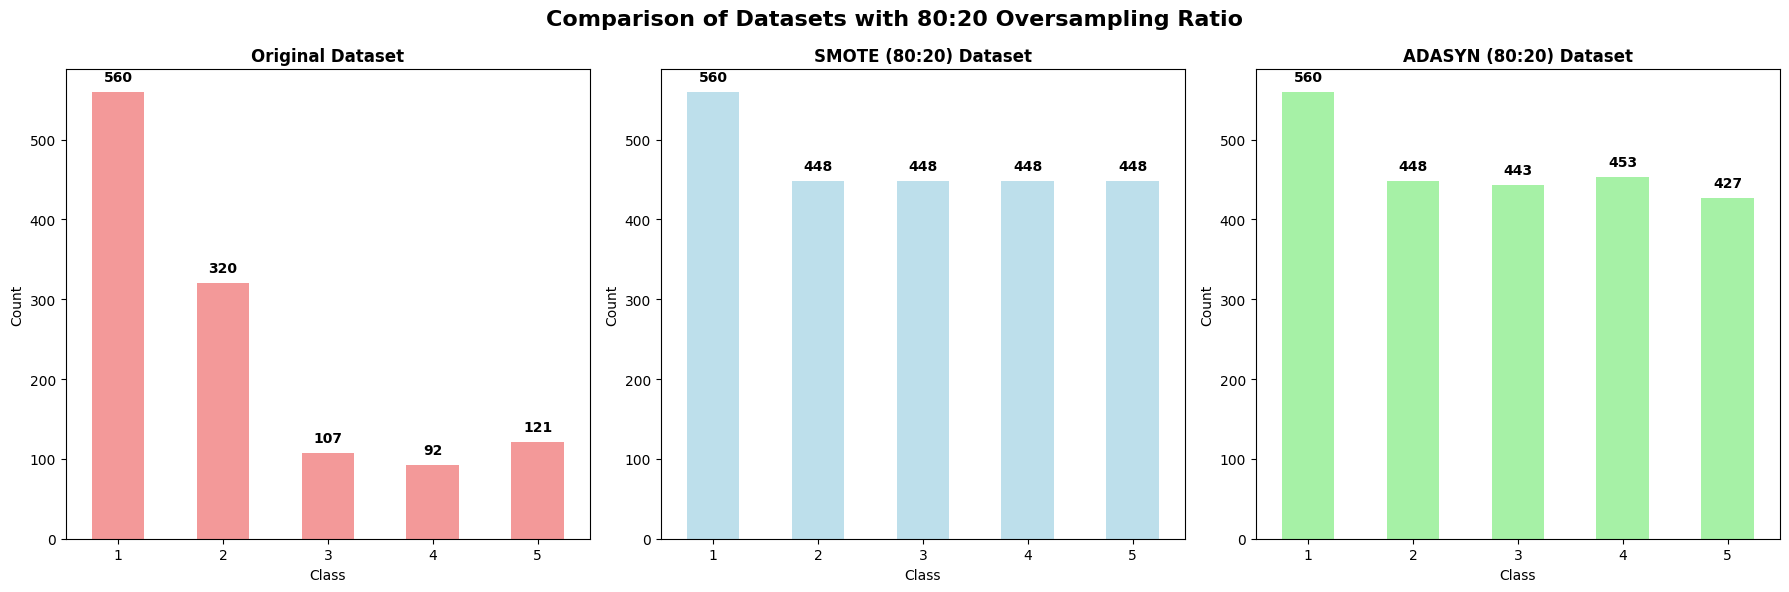


📈 Summary:
✅ Successfully applied 80:20 ratio oversampling
✅ Reduced dataset size compared to full balancing
✅ Maintained reasonable class balance while controlling data growth


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Original train set distribution:")
original_train_dist = y_train.value_counts()
display(original_train_dist)
print(f"Train set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def apply_oversampling_custom_ratio(X_train, y_train, ratio=0.8):
    original_dist = pd.Series(y_train).value_counts()
    majority_class_count = original_dist.max()
    target_count = int(majority_class_count * ratio)
    
    sampling_strategy = {}
    for class_label in original_dist.index:
        current_count = original_dist[class_label]
        if current_count < target_count:
            sampling_strategy[class_label] = target_count
        else:
            sampling_strategy[class_label] = current_count
    
    original_data = {"X": X_train, "y": y_train, "name": "Original"}

    smote = SMOTE(random_state=42, k_neighbors=3, sampling_strategy=sampling_strategy)
    X_smote, y_smote = smote.fit_resample(X_train, y_train)
    smote_data = {"X": X_smote, "y": y_smote, "name": "SMOTE (80:20)"}

    adasyn = ADASYN(random_state=42, n_neighbors=3, sampling_strategy=sampling_strategy)
    X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)
    adasyn_data = {"X": X_adasyn, "y": y_adasyn, "name": "ADASYN (80:20)"}

    return [original_data, smote_data, adasyn_data]
datasets = apply_oversampling_custom_ratio(X_train_scaled, y_train, ratio=0.8)
print("Oversampling Results (80:20 Ratio):")
print("=" * 70)
for dataset in datasets:
    print(f"\n{dataset['name']} Dataset:")
    print(f"Shape: {dataset['X'].shape}")
    print(f"Class distribution:")
    class_dist = pd.Series(dataset["y"]).value_counts().sort_index()
    for class_name, count in class_dist.items():
        percentage = (count / len(dataset["y"])) * 100
        print(f"  Class {class_name}: {count:4d} samples ({percentage:5.1f}%)")
    min_count = class_dist.min()
    max_count = class_dist.max()
    balance_ratio = max_count / min_count
    print(f"  Balance Ratio (Max/Min): {balance_ratio:.2f}")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, dataset in enumerate(datasets):
    class_dist = pd.Series(dataset["y"]).value_counts().sort_index()
    colors = ['lightcoral', 'lightblue', 'lightgreen']
    
    class_dist.plot(kind='bar', ax=axes[i], color=colors[i], alpha=0.8)
    axes[i].set_title(f'{dataset["name"]} Dataset', fontweight='bold', fontsize=12)
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Class')
    axes[i].tick_params(axis='x', rotation=0)
  
    for j, (class_label, count) in enumerate(class_dist.items()):
        axes[i].text(j, count + 10, str(count), ha='center', va='bottom', fontweight='bold')

plt.suptitle('Comparison of Datasets with 80:20 Oversampling Ratio', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n📈 Summary:")
print(f"✅ Successfully applied 80:20 ratio oversampling")
print(f"✅ Reduced dataset size compared to full balancing")
print(f"✅ Maintained reasonable class balance while controlling data growth")

## 🚀 4. Ensemble Methods Comparison

In [19]:


# Encode target variable for XGBoost compatibility
target_encoder = LabelEncoder()
y_train_encoded = target_encoder.fit_transform(y_train)
y_test_encoded = target_encoder.transform(y_test)

# For SMOTE and ADASYN, encode the oversampled targets
y_train_smote_encoded = (
    target_encoder.transform(y_train_smote)
    if "y_train_smote" in locals()
    else y_train_encoded
)
y_train_adasyn_encoded = (
    target_encoder.transform(y_train_adasyn)
    if "y_train_adasyn" in locals()
    else y_train_encoded
)

# Initialize simple models for quick comparison
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=50, random_state=42, n_jobs=-1
    ),
    "XGBoost": XGBClassifier(
        n_estimators=50, random_state=42, eval_metric="mlogloss", verbosity=0
    ),
    "LightGBM": LGBMClassifier(n_estimators=50, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=50, random_state=42
    ),
}

# Datasets to compare (using encoded targets for compatibility)
datasets = {
    "Original": (X_train_scaled, y_train_encoded),
    "SMOTE": (
        (X_train_smote, y_train_smote_encoded)
        if "X_train_smote" in locals()
        else (X_train_scaled, y_train_encoded)
    ),
    "ADASYN": (
        (X_train_adasyn, y_train_adasyn_encoded)
        if "X_train_adasyn" in locals()
        else (X_train_scaled, y_train_encoded)
    ),
}

# Store results
comparison_results = {}

print(f"\n🔄 Running quick comparison...")

for dataset_name, (X_tr, y_tr) in datasets.items():
    print(f"\n📊 Testing with {dataset_name} dataset:")
    comparison_results[dataset_name] = {}

    for model_name, model in models.items():
        try:
            # Train model
            model.fit(X_tr, y_tr)

            # Predict on test set
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled)

            # Calculate metrics
            accuracy = accuracy_score(y_test_encoded, y_pred)
            f1_weighted = f1_score(y_test_encoded, y_pred, average="weighted")
            f1_macro = f1_score(y_test_encoded, y_pred, average="macro")

            # Calculate AUC (handle multi-class)
            if len(np.unique(y_test_encoded)) > 2:
                # Multi-class AUC
                auc_score = roc_auc_score(
                    y_test_encoded, y_pred_proba, multi_class="ovr", average="weighted"
                )
            else:
                # Binary AUC
                auc_score = roc_auc_score(y_test_encoded, y_pred_proba[:, 1])

            # Calculate Sensitivity and Specificity
            cm = confusion_matrix(y_test_encoded, y_pred)

            # For multi-class classification, calculate average sensitivity and specificity
            if len(cm) > 2:
                # Sensitivity (Recall) for each class
                sensitivity_per_class = cm.diagonal() / cm.sum(axis=1)
                sensitivity = np.mean(sensitivity_per_class)

                # Specificity for each class
                specificity_per_class = []
                for i in range(len(cm)):
                    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
                    fp = cm[:, i].sum() - cm[i, i]
                    specificity_per_class.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
                specificity = np.mean(specificity_per_class)
            else:
                # Binary classification
                tn, fp, fn, tp = cm.ravel()
                sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
                specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

            comparison_results[dataset_name][model_name] = {
                "Accuracy": accuracy,
                "F1_Weighted": f1_weighted,
                "F1_Macro": f1_macro,
                "AUC": auc_score,
                "Sensitivity": sensitivity,
                "Specificity": specificity,
            }

            print(
                f"  {model_name:15}: Acc={accuracy:.4f}, AUC={auc_score:.4f}, Sens={sensitivity:.4f}, Spec={specificity:.4f}"
            )

        except Exception as e:
            print(f"  ❌ {model_name} failed: {e}")
            comparison_results[dataset_name][model_name] = {
                "Accuracy": 0,
                "F1_Weighted": 0,
                "F1_Macro": 0,
                "AUC": 0,
                "Sensitivity": 0,
                "Specificity": 0,
            }

# Create comparison DataFrame
results_list = []
for dataset_name, dataset_results in comparison_results.items():
    for model_name, metrics in dataset_results.items():
        if metrics["Accuracy"] > 0:  # Only include successful runs
            results_list.append(
                {
                    "Dataset": dataset_name,
                    "Model": model_name,
                    "Accuracy": metrics["Accuracy"],
                    "AUC": metrics["AUC"],
                    "Sensitivity": metrics["Sensitivity"],
                    "Specificity": metrics["Specificity"],
                    "F1_Weighted": metrics["F1_Weighted"],
                    "F1_Macro": metrics["F1_Macro"],
                }
            )

results_df = pd.DataFrame(results_list)

if len(results_df) > 0:
    print(f"\n📈 Quick Comparison Results:")
    print("=" * 80)

    # 🔥 ENHANCED: Create interactive DataTable with better styling
    def create_enhanced_interactive_table(results_df):
        # Add color scaling for better visualization
        def color_scale(val, metric):
            if metric in [
                "Accuracy",
                "AUC",
                "Sensitivity",
                "Specificity",
                "F1_Weighted",
                "F1_Macro",
            ]:
                if val >= 0.9:
                    return "#2E8B57"  # Green for excellent
                elif val >= 0.8:
                    return "#3CB371"  # Light green for good
                elif val >= 0.7:
                    return "#FFD700"  # Yellow for average
                elif val >= 0.6:
                    return "#FFA500"  # Orange for below average
                else:
                    return "#FF6347"  # Red for poor
            return "#FFFFFF"

        # Prepare cell colors
        cell_colors = []
        for col in [
            "Accuracy",
            "AUC",
            "Sensitivity",
            "Specificity",
            "F1_Weighted",
            "F1_Macro",
        ]:
            cell_colors.append([color_scale(val, col) for val in results_df[col]])

        fig = go.Figure(
            data=[
                go.Table(
                    header=dict(
                        values=[
                            "<b>Dataset</b>",
                            "<b>Model</b>",
                            "<b>Accuracy</b>",
                            "<b>AUC</b>",
                            "<b>Sensitivity</b>",
                            "<b>Specificity</b>",
                            "<b>F1 Weighted</b>",
                            "<b>F1 Macro</b>",
                        ],
                        fill_color="#1f77b4",
                        align=[
                            "center",
                            "center",
                            "center",
                            "center",
                            "center",
                            "center",
                            "center",
                            "center",
                        ],
                        font=dict(color="white", size=13, family="Arial Black"),
                        height=45,
                        line=dict(color="white", width=1),
                    ),
                    cells=dict(
                        values=[
                            results_df["Dataset"],
                            results_df["Model"],
                            results_df["Accuracy"].round(4),
                            results_df["AUC"].round(4),
                            results_df["Sensitivity"].round(4),
                            results_df["Specificity"].round(4),
                            results_df["F1_Weighted"].round(4),
                            results_df["F1_Macro"].round(4),
                        ],
                        fill_color=[
                            [
                                "#F8F9FA" if i % 2 == 0 else "#E9ECEF"
                                for i in range(len(results_df))
                            ],  # Dataset
                            [
                                "#F8F9FA" if i % 2 == 0 else "#E9ECEF"
                                for i in range(len(results_df))
                            ],  # Model
                            cell_colors[0],  # Accuracy with color scale
                            cell_colors[1],  # AUC with color scale
                            cell_colors[2],  # Sensitivity with color scale
                            cell_colors[3],  # Specificity with color scale
                            cell_colors[4],  # F1 Weighted with color scale
                            cell_colors[5],  # F1 Macro with color scale
                        ],
                        align=[
                            "center",
                            "center",
                            "center",
                            "center",
                            "center",
                            "center",
                            "center",
                            "center",
                        ],
                        font=dict(color="black", size=11, family="Arial"),
                        height=35,
                        line=dict(color="white", width=0.5),
                    ),
                )
            ]
        )

        fig.update_layout(
            title=dict(
                text="<b>📊 Enhanced Model Comparison Results</b><br><sub>Color scale: 🟢 ≥0.9 | 🟡 0.8-0.9 | 🟠 0.7-0.8 | 🔴 <0.7</sub>",
                x=0.5,
                font=dict(size=18, color="#1f77b4", family="Arial Black"),
            ),
            width=1300,
            height=720,
            margin=dict(l=10, r=10, t=100, b=10),
            paper_bgcolor="white",
        )

        return fig

    # Display enhanced interactive table
    enhanced_table_fig = create_enhanced_interactive_table(results_df)
    enhanced_table_fig.show()

    # 🔥 ENHANCED: Create radar chart for comprehensive comparison
    def create_radar_chart(results_df):
        categories = [
            "Accuracy",
            "AUC",
            "Sensitivity",
            "Specificity",
            "F1_Weighted",
            "F1_Macro",
        ]

        fig = go.Figure()

        colors = px.colors.qualitative.Set3
        for i, (idx, row) in enumerate(results_df.iterrows()):
            values = [row[col] for col in categories]
            # Close the radar chart
            values_with_closure = values + [values[0]]
            categories_with_closure = categories + [categories[0]]

            fig.add_trace(
                go.Scatterpolar(
                    r=values_with_closure,
                    theta=categories_with_closure,
                    fill="toself",
                    name=f"{row['Dataset']} - {row['Model']}",
                    line=dict(color=colors[i % len(colors)], width=2),
                    opacity=0.8,
                )
            )

        fig.update_layout(
            polar=dict(
                radialaxis=dict(visible=True, range=[0, 1], tickfont=dict(size=10)),
                angularaxis=dict(tickfont=dict(size=11)),
            ),
            title=dict(
                text="<b>🔄 Radar Chart - Comprehensive Model Comparison</b>",
                x=0.5,
                font=dict(size=16, color="#1f77b4"),
            ),
            showlegend=True,
            legend=dict(
                orientation="v", yanchor="middle", y=0.5, xanchor="left", x=1.1
            ),
            width=800,
            height=600,
        )

        return fig

    # Display radar chart
    radar_fig = create_radar_chart(results_df)
    radar_fig.show()

    # 🔥 ENHANCED: Create performance heatmap
    def create_performance_heatmap(results_df):
        # Prepare data for heatmap
        heatmap_data = []
        model_names = []
        for metric in [
            "Accuracy",
            "AUC",
            "Sensitivity",
            "Specificity",
            "F1_Weighted",
            "F1_Macro",
        ]:
            row_data = []
            for _, row in results_df.iterrows():
                row_data.append(row[metric])
            heatmap_data.append(row_data)

        model_names = [
            f"{row['Dataset']}<br>{row['Model']}" for _, row in results_df.iterrows()
        ]
        metric_names = [
            "Accuracy",
            "AUC",
            "Sensitivity",
            "Specificity",
            "F1 Weighted",
            "F1 Macro",
        ]

        fig = go.Figure(
            data=go.Heatmap(
                z=heatmap_data,
                x=model_names,
                y=metric_names,
                colorscale="Viridis",
                hoverongaps=False,
                text=[[f"{val:.4f}" for val in row] for row in heatmap_data],
                texttemplate="%{text}",
                textfont={"size": 11},
                colorbar=dict(title="Score"),
            )
        )

        fig.update_layout(
            title=dict(
                text="<b>🔥 Performance Heatmap - All Models & Metrics</b>",
                x=0.5,
                font=dict(size=16, color="#1f77b4"),
            ),
            xaxis_title="Model Combinations",
            yaxis_title="Metrics",
            width=900,
            height=500,
            margin=dict(l=50, r=50, t=80, b=50),
        )

        return fig

    # Display heatmap
    heatmap_fig = create_performance_heatmap(results_df)
    heatmap_fig.show()

    # 🔥 ENHANCED: Create summary dashboard
    def create_summary_dashboard(results_df):
        # Calculate overall rankings
        results_df["Overall_Score"] = results_df[
            ["Accuracy", "AUC", "F1_Weighted", "Sensitivity", "Specificity"]
        ].mean(axis=1)
        results_df["Rank"] = (
            results_df["Overall_Score"].rank(ascending=False).astype(int)
        )

        fig = make_subplots(
            rows=2,
            cols=1,
            subplot_titles=(
                "🏆 Overall Ranking",
                "🎯 Performance Distribution",
            ),
            specs=[
                [{"type": "table"}],
                [{"type": "bar"}],
            ],
            vertical_spacing=0.12,
            horizontal_spacing=0.1,
        )

        # Subplot 1: Ranking table
        ranking_table = go.Table(
            header=dict(
                values=[
                    "<b>Rank</b>",
                    "<b>Dataset</b>",
                    "<b>Model</b>",
                    "<b>Overall Score</b>",
                ],
                fill_color="#1f77b4",
                align=["center", "center", "center", "center"],
                font=dict(color="white", size=12),
            ),
            cells=dict(
                values=[
                    results_df["Rank"],
                    results_df["Dataset"],
                    results_df["Model"],
                    results_df["Overall_Score"].round(4),
                ],
                fill_color=[
                    "#F8F9FA" if i % 2 == 0 else "#E9ECEF"
                    for i in range(len(results_df))
                ],
                align=["center", "center", "center", "center"],
                font=dict(size=11),
            ),
        )

        fig.add_trace(ranking_table, row=1, col=1)

        # Subplot 2: Key metrics bar chart
        key_metrics = ["Accuracy", "AUC", "F1_Weighted"]
        for i, metric in enumerate(key_metrics):
            fig.add_trace(
                go.Bar(
                    name=metric,
                    x=[
                        f"{row['Dataset']}\n{row['Model']}"
                        for _, row in results_df.iterrows()
                    ],
                    y=results_df[metric],
                    text=results_df[metric].round(4),
                    textposition="auto",
                    marker_color=px.colors.qualitative.Set2[i],
                ),
                row=2,
                col=1,
            )

        
        fig.update_layout(
            title=dict(
                text="<b>📊 Comprehensive Model Analysis Dashboard</b>",
                x=0.5,
                font=dict(size=18, color="#1f77b4"),
            ),
            height=800,
            showlegend=True,
            legend=dict(
                orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1
            ),
        )

        return fig

    # Display summary dashboard
    dashboard_fig = create_summary_dashboard(results_df)
    dashboard_fig.show()

    # Find best combination by F1-Weighted
    best_combo = results_df.loc[results_df["F1_Weighted"].idxmax()]

    # 🔥 ENHANCED: Create interactive best model card
    best_model_html = f"""
    <div style="
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        padding: 25px;
        border-radius: 15px;
        color: white;
        text-align: center;
        margin: 25px 0;
        box-shadow: 0 8px 25px rgba(0,0,0,0.3);
        border: 2px solid #fff;
        position: relative;
        overflow: hidden;
    ">
        <div style="position: absolute; top: -50px; right: -50px; width: 150px; height: 150px; 
                    background: rgba(255,255,255,0.1); border-radius: 50%;"></div>
        <div style="position: absolute; bottom: -30px; left: -30px; width: 100px; height: 100px; 
                    background: rgba(255,255,255,0.1); border-radius: 50%;"></div>
        
        <h2 style="margin: 0 0 20px 0; font-size: 28px; text-shadow: 2px 2px 4px rgba(0,0,0,0.3);">
            🏆 BEST PERFORMING MODEL
        </h2>
        
        <div style="display: grid; grid-template-columns: 1fr 1fr 1fr; gap: 20px; margin-bottom: 20px;">
            <div style="background: rgba(255,255,255,0.2); padding: 15px; border-radius: 10px;">
                <h3 style="margin: 0 0 10px 0; font-size: 16px; opacity: 0.9;">Dataset</h3>
                <p style="margin: 0; font-size: 20px; font-weight: bold;">{best_combo['Dataset']}</p>
            </div>
            <div style="background: rgba(255,255,255,0.2); padding: 15px; border-radius: 10px;">
                <h3 style="margin: 0 0 10px 0; font-size: 16px; opacity: 0.9;">Model</h3>
                <p style="margin: 0; font-size: 20px; font-weight: bold;">{best_combo['Model']}</p>
            </div>
            <div style="background: rgba(255,255,255,0.2); padding: 15px; border-radius: 10px;">
                <h3 style="margin: 0 0 10px 0; font-size: 16px; opacity: 0.9;">F1-Weighted</h3>
                <p style="margin: 0; font-size: 20px; font-weight: bold; color: #FFD700;">{best_combo['F1_Weighted']:.4f}</p>
            </div>
        </div>
        
        <div style="display: grid; grid-template-columns: 1fr 1fr 1fr 1fr; gap: 15px;">
            <div style="background: rgba(255,255,255,0.15); padding: 12px; border-radius: 8px;">
                <p style="margin: 0; font-size: 14px;">Accuracy</p>
                <p style="margin: 5px 0 0 0; font-size: 16px; font-weight: bold;">{best_combo['Accuracy']:.4f}</p>
            </div>
            <div style="background: rgba(255,255,255,0.15); padding: 12px; border-radius: 8px;">
                <p style="margin: 0; font-size: 14px;">AUC</p>
                <p style="margin: 5px 0 0 0; font-size: 16px; font-weight: bold;">{best_combo['AUC']:.4f}</p>
            </div>
            <div style="background: rgba(255,255,255,0.15); padding: 12px; border-radius: 8px;">
                <p style="margin: 0; font-size: 14px;">Sensitivity</p>
                <p style="margin: 5px 0 0 0; font-size: 16px; font-weight: bold;">{best_combo['Sensitivity']:.4f}</p>
            </div>
            <div style="background: rgba(255,255,255,0.15); padding: 12px; border-radius: 8px;">
                <p style="margin: 0; font-size: 14px;">Specificity</p>
                <p style="margin: 5px 0 0 0; font-size: 16px; font-weight: bold;">{best_combo['Specificity']:.4f}</p>
            </div>
        </div>
    </div>
    """

    display(HTML(best_model_html))

    # Choose best dataset for ensemble comparison
    if best_combo["Dataset"] == "SMOTE":
        best_X_train, best_y_train = X_train_smote, y_train_smote_encoded
        best_oversampling = "SMOTE"
    elif best_combo["Dataset"] == "ADASYN":
        best_X_train, best_y_train = X_train_adasyn, y_train_adasyn_encoded
        best_oversampling = "ADASYN"
    else:
        best_X_train, best_y_train = X_train_scaled, y_train_encoded
        best_oversampling = "Original"

    print(f"\n✅ Selected dataset for ensemble comparison: {best_oversampling}")
    print(f"📊 Selected dataset shape: {best_X_train.shape}")

else:
    print("❌ No successful model runs - using original dataset")
    best_X_train, best_y_train = X_train_scaled, y_train_encoded
    best_oversampling = "Original"


🔄 Running quick comparison...

📊 Testing with Original dataset:
  Random Forest  : Acc=0.8467, AUC=0.9770, Sens=0.6544, Spec=0.9664
  XGBoost        : Acc=0.8367, AUC=0.9773, Sens=0.6371, Spec=0.9642
  LightGBM       : Acc=0.8367, AUC=0.9779, Sens=0.6364, Spec=0.9642
  Gradient Boosting: Acc=0.8433, AUC=0.9797, Sens=0.6436, Spec=0.9656

📊 Testing with SMOTE dataset:
  Random Forest  : Acc=0.8467, AUC=0.9770, Sens=0.6544, Spec=0.9664
  XGBoost        : Acc=0.8367, AUC=0.9773, Sens=0.6371, Spec=0.9642
  LightGBM       : Acc=0.8367, AUC=0.9779, Sens=0.6364, Spec=0.9642
  Gradient Boosting: Acc=0.8433, AUC=0.9797, Sens=0.6436, Spec=0.9656

📊 Testing with ADASYN dataset:
  Random Forest  : Acc=0.8467, AUC=0.9770, Sens=0.6544, Spec=0.9664
  XGBoost        : Acc=0.8367, AUC=0.9773, Sens=0.6371, Spec=0.9642
  LightGBM       : Acc=0.8367, AUC=0.9779, Sens=0.6364, Spec=0.9642
  Gradient Boosting: Acc=0.8433, AUC=0.9797, Sens=0.6436, Spec=0.9656

📈 Quick Comparison Results:



✅ Selected dataset for ensemble comparison: Original
📊 Selected dataset shape: (1200, 12)


## ⚙️ 5. Hyperparameter Tuning

In [20]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import time
from IPython.display import display, HTML

print("🎯 STARTING HYPERPARAMETER TUNING FOR BEST PERFORMING MODEL")

# 🔥 ENHANCED: Identify the best performing model from ensemble comparison
print(f"\n🔍 Identifying best performing model from previous comparison...")
print("=" * 80)

# Find the best model combination from the ensemble comparison results
if 'results_df' in locals() and len(results_df) > 0:
    # Filter results for the best dataset
    best_dataset_results = results_df[results_df['Dataset'] == best_combo['Dataset']]
    
    # Get the best model based on F1_Weighted score
    best_model_row = best_dataset_results.loc[best_dataset_results['F1_Weighted'].idxmax()]
    best_model_name = best_model_row['Model']
    
    print(f"🏆 Best performing combination identified:")
    print(f"   📊 Dataset: {best_model_row['Dataset']}")
    print(f"   🤖 Model: {best_model_name}")
    print(f"   📈 F1-Weighted Score: {best_model_row['F1_Weighted']:.4f}")
    print(f"   🎯 Accuracy: {best_model_row['Accuracy']:.4f}")
    print(f"   📊 AUC: {best_model_row['AUC']:.4f}")
    
else:
    # Fallback to Random Forest if no previous results
    best_model_name = "Random Forest"
    print(f"⚠️ No previous results found, defaulting to {best_model_name}")

print(f"\n🎯 Performing hyperparameter tuning ONLY for: {best_model_name}")
print("=" * 80)

# Define hyperparameter grids for each model
param_grids = {
    "Random Forest": {
        "n_estimators": [50, 100, 200, 300, 500],
        "max_depth": [10, 15, 20, 25, 30, None],
        "min_samples_split": [2, 5, 10, 15],
        "min_samples_leaf": [1, 2, 4, 6],
        "max_features": ["sqrt", "log2", None, 0.5, 0.7],
        "bootstrap": [True, False],
        "criterion": ["gini", "entropy"]
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200, 300, 500],
        "max_depth": [3, 5, 7, 9, 11],
        "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
        "subsample": [0.7, 0.8, 0.9, 1.0],
        "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
        "gamma": [0, 0.1, 0.2, 0.3, 0.5],
        "reg_alpha": [0, 0.1, 0.5, 1, 2],
        "reg_lambda": [0, 0.1, 0.5, 1, 2],
        "min_child_weight": [1, 3, 5, 7]
    },
    "LightGBM": {
        "n_estimators": [50, 100, 200, 300, 500],
        "max_depth": [3, 5, 7, 9, 11, -1],  # -1 means no limit
        "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
        "num_leaves": [31, 50, 100, 200, 300],
        "subsample": [0.7, 0.8, 0.9, 1.0],
        "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
        "reg_alpha": [0, 0.1, 0.5, 1, 2],
        "reg_lambda": [0, 0.1, 0.5, 1, 2],
        "min_child_samples": [20, 30, 50, 100],
        "subsample_freq": [0, 1, 3, 5]
    },
    "Gradient Boosting": {
        "n_estimators": [50, 100, 200, 300, 500],
        "max_depth": [3, 5, 7, 9, 11],
        "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
        "subsample": [0.7, 0.8, 0.9, 1.0],
        "max_features": ["sqrt", "log2", None, 0.5, 0.7],
        "min_samples_split": [2, 5, 10, 15],
        "min_samples_leaf": [1, 2, 4, 6],
        "loss": ["log_loss", "exponential"],
        "criterion": ["friedman_mse", "squared_error"]
    }
}

# Initialize only the best performing model
base_models = {
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, eval_metric="mlogloss", verbosity=0),
    "LightGBM": LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Select only the best model for tuning
if best_model_name in base_models:
    selected_model = {best_model_name: base_models[best_model_name]}
    selected_param_grid = {best_model_name: param_grids[best_model_name]}
else:
    # Fallback
    selected_model = {"Random Forest": base_models["Random Forest"]}
    selected_param_grid = {"Random Forest": param_grids["Random Forest"]}
    best_model_name = "Random Forest"

# Store tuning results
tuning_results = {}
best_models = {}
tuning_times = {}

# Perform RandomizedSearchCV for the best model only
print(f"\n🔍 Performing Hyperparameter Tuning for {best_model_name}...")
print("=" * 80)

model = selected_model[best_model_name]
param_grid = selected_param_grid[best_model_name]

print(f"\n🎯 Tuning {best_model_name}...")
print(f"   📊 Parameter space size: {np.prod([len(v) if isinstance(v, list) else 1 for v in param_grid.values()])} combinations")
print(f"   🔍 Testing 50 random combinations with 5-fold CV...")

start_time = time.time()

try:
    # Enhanced Randomized Search with more iterations for better results
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=50,  # Increased iterations for better parameter exploration
        cv=5,       # 5-fold cross-validation for more robust evaluation
        scoring='f1_weighted',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    # Fit the model
    print(f"   🚀 Starting hyperparameter search...")
    random_search.fit(best_X_train, best_y_train)
    
    # Store results
    best_models[best_model_name] = random_search.best_estimator_
    tuning_results[best_model_name] = {
        'best_params': random_search.best_params_,
        'best_score': random_search.best_score_,
        'best_estimator': random_search.best_estimator_,
        'cv_results': random_search.cv_results_
    }
    
    tuning_time = time.time() - start_time
    tuning_times[best_model_name] = tuning_time
    
    print(f"✅ {best_model_name} tuning completed in {tuning_time:.2f} seconds")
    print(f"   🏆 Best CV Score (F1-weighted): {random_search.best_score_:.4f}")
    print(f"   📊 Best Parameters:")
    for param, value in random_search.best_params_.items():
        print(f"      {param}: {value}")
        
except Exception as e:
    print(f"❌ {best_model_name} tuning failed: {e}")
    # Use base model as fallback
    best_models[best_model_name] = model
    best_models[best_model_name].fit(best_X_train, best_y_train)
    tuning_results[best_model_name] = {
        'best_params': "Tuning failed - using default",
        'best_score': 0,
        'best_estimator': model
    }

# Evaluate tuned model on test set
print(f"\n📊 Evaluating Tuned {best_model_name} on Test Set...")
print("=" * 80)

tuned_results = []

model_obj = best_models[best_model_name]

try:
    # Predict on test set
    y_pred = model_obj.predict(X_test_scaled)
    y_pred_proba = model_obj.predict_proba(X_test_scaled)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_encoded, y_pred)
    f1_weighted = f1_score(y_test_encoded, y_pred, average="weighted")
    f1_macro = f1_score(y_test_encoded, y_pred, average="macro")
    
    # Calculate AUC
    if len(np.unique(y_test_encoded)) > 2:
        auc_score = roc_auc_score(
            y_test_encoded, y_pred_proba, multi_class="ovr", average="weighted"
        )
    else:
        auc_score = roc_auc_score(y_test_encoded, y_pred_proba[:, 1])
    
    # Calculate Sensitivity and Specificity
    cm = confusion_matrix(y_test_encoded, y_pred)
    
    if len(cm) > 2:
        sensitivity_per_class = cm.diagonal() / cm.sum(axis=1)
        sensitivity = np.mean(sensitivity_per_class)
        specificity_per_class = []
        for i in range(len(cm)):
            tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
            fp = cm[:, i].sum() - cm[i, i]
            specificity_per_class.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
        specificity = np.mean(specificity_per_class)
    else:
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Get CV (cross-validation) score from tuning
    cv_score = tuning_results[best_model_name]['best_score']
    
    tuned_results.append({
        "Model": best_model_name,
        "CV_Score": cv_score,
        "Accuracy": accuracy,
        "AUC": auc_score,
        "F1_Weighted": f1_weighted,
        "F1_Macro": f1_macro,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Tuning_Time": tuning_times.get(best_model_name, 0)
    })
    
    print(f"✅ {best_model_name:20}: "
          f"CV={cv_score:.4f}, "
          f"Test_Acc={accuracy:.4f}, "
          f"Test_F1={f1_weighted:.4f}, "
          f"AUC={auc_score:.4f}")
          
except Exception as e:
    print(f"❌ {best_model_name} evaluation failed: {e}")

# Create results DataFrame
tuned_results_df = pd.DataFrame(tuned_results)

if len(tuned_results_df) > 0:
    # 🔥 ENHANCED: Create comprehensive tuning results visualization
    
    # 1. Detailed Tuning Results for Best Model
    def create_detailed_tuning_results(best_model_name, tuning_results):
        if best_model_name in tuning_results and 'cv_results' in tuning_results[best_model_name]:
            cv_results = tuning_results[best_model_name]['cv_results']
            
            # Create DataFrame from CV results
            cv_df = pd.DataFrame({
                'mean_test_score': cv_results['mean_test_score'],
                'std_test_score': cv_results['std_test_score'],
                'mean_fit_time': cv_results['mean_fit_time'],
                'params': cv_results['params']
            })
            
            # Sort by score
            cv_df = cv_df.sort_values('mean_test_score', ascending=False)
            
            # Create visualization
            fig = make_subplots(
                rows=2, cols=2,
                subplot_titles=(
                    f'🏆 Top 10 Parameter Combinations - {best_model_name}',
                    f'📊 Score Distribution - {best_model_name}',
                    f'⏱️ Training Time vs Performance - {best_model_name}',
                    f'🎯 Score Evolution - {best_model_name}'
                ),
                specs=[[{"type": "table"}, {"type": "histogram"}],
                       [{"type": "scatter"}, {"type": "scatter"}]]
            )
            
            # Top 10 parameters table
            top_10 = cv_df.head(10)
            fig.add_trace(
                go.Table(
                    header=dict(
                        values=['<b>Rank</b>', '<b>CV Score</b>', '<b>Std</b>', '<b>Parameters</b>'],
                        fill_color='#1f77b4',
                        align=['center'] * 4,
                        font=dict(color='white', size=11)
                    ),
                    cells=dict(
                        values=[
                            list(range(1, 11)),
                            [f"{score:.4f}" for score in top_10['mean_test_score']],
                            [f"{std:.4f}" for std in top_10['std_test_score']],
                            [str(params)[:50] + "..." if len(str(params)) > 50 else str(params) for params in top_10['params']]
                        ],
                        fill_color='#f8f9fa',
                        align=['center'] * 4,
                        font=dict(size=10)
                    )
                ),
                row=1, col=1
            )
            
            # Score distribution
            fig.add_trace(
                go.Histogram(
                    x=cv_df['mean_test_score'],
                    nbinsx=20,
                    name='Score Distribution',
                    marker_color='lightblue',
                    opacity=0.7
                ),
                row=1, col=2
            )
            
            # Training time vs performance
            fig.add_trace(
                go.Scatter(
                    x=cv_df['mean_fit_time'],
                    y=cv_df['mean_test_score'],
                    mode='markers',
                    marker=dict(
                        size=8,
                        color=cv_df['mean_test_score'],
                        colorscale='Viridis',
                        showscale=True
                    ),
                    name='Time vs Performance'
                ),
                row=2, col=1
            )
            
            # Score evolution (by trial order)
            fig.add_trace(
                go.Scatter(
                    x=list(range(len(cv_df))),
                    y=cv_df['mean_test_score'].values,
                    mode='lines+markers',
                    name='Score Evolution',
                    line=dict(color='orange', width=2),
                    marker=dict(size=6)
                ),
                row=2, col=2
            )
            
            fig.update_layout(
                title=dict(
                    text=f'<b>🔍 Detailed Hyperparameter Tuning Analysis - {best_model_name}</b>',
                    x=0.5,
                    font=dict(size=16, color='#1f77b4')
                ),
                height=800,
                showlegend=False
            )
            
            return fig
        return None

    # Display detailed tuning analysis
    detailed_fig = create_detailed_tuning_results(best_model_name, tuning_results)
    if detailed_fig:
        detailed_fig.show()

    # 2. Performance Comparison: Before vs After Tuning
    def create_before_after_comparison_single(original_results, tuned_results, best_model_name, best_dataset):
        # Extract original results for the best model
        original_metrics = {}
        original_match = original_results[
            (original_results['Dataset'] == best_dataset) & 
            (original_results['Model'] == best_model_name)
        ]
        
        if len(original_match) > 0:
            original_row = original_match.iloc[0]
            original_metrics = {
                'Accuracy': original_row['Accuracy'],
                'F1_Weighted': original_row['F1_Weighted'],
                'AUC': original_row['AUC']
            }
            
            # Get tuned results
            tuned_row = tuned_results.iloc[0]
            
            # Create comparison data
            metrics = ['Accuracy', 'F1_Weighted', 'AUC']
            before_values = [original_metrics[m] for m in metrics]
            after_values = [tuned_row[m] for m in metrics]
            improvements = [after - before for before, after in zip(before_values, after_values)]
            
            # Create visualization
            fig = go.Figure()
            
            x_labels = [f'{m}' for m in metrics]
            
            # Before bars
            fig.add_trace(go.Bar(
                name='Before Tuning',
                x=x_labels,
                y=before_values,
                marker_color='lightcoral',
                text=[f'{v:.4f}' for v in before_values],
                textposition='auto',
                opacity=0.8
            ))
            
            # After bars
            fig.add_trace(go.Bar(
                name='After Tuning',
                x=x_labels,
                y=after_values,
                marker_color='lightgreen',
                text=[f'{v:.4f}' for v in after_values],
                textposition='auto',
                opacity=0.8
            ))
            
            # Add improvement annotations
            for i, (metric, improvement) in enumerate(zip(metrics, improvements)):
                fig.add_annotation(
                    x=i,
                    y=max(before_values[i], after_values[i]) + 0.02,
                    text=f'Δ: {improvement:+.4f}',
                    showarrow=False,
                    font=dict(size=12, color='darkblue', family='Arial Black')
                )
            
            fig.update_layout(
                title=dict(
                    text=f'<b>📈 Performance Improvement: {best_model_name} on {best_dataset} Dataset</b>',
                    x=0.5,
                    font=dict(size=16, color='#1f77b4')
                ),
                barmode='group',
                xaxis_title="Metrics",
                yaxis_title="Score",
                height=500,
                showlegend=True,
                yaxis=dict(range=[0, 1])
            )
            
            return fig, improvements
        
        return None, []

    # Create before-after comparison
    if 'results_df' in locals():
        before_after_fig, improvements = create_before_after_comparison_single(
            results_df, tuned_results_df, best_model_name, best_combo['Dataset']
        )
        if before_after_fig:
            before_after_fig.show()

    # 3. Best Model Summary Card
    tuned_model_result = tuned_results_df.iloc[0]
    
    # Calculate improvement from original
    improvement = 0
    original_f1 = 0
    if 'results_df' in locals() and len(results_df) > 0:
        original_match = results_df[
            (results_df['Dataset'] == best_combo['Dataset']) & 
            (results_df['Model'] == best_model_name)
        ]
        if len(original_match) > 0:
            original_f1 = original_match['F1_Weighted'].values[0]
            improvement = tuned_model_result['F1_Weighted'] - original_f1

    # Create enhanced model card
    best_tuned_html = f"""
    <div style="
        background: linear-gradient(135deg, #4a90e2 0%, #7b68ee 100%);
        padding: 30px;
        border-radius: 20px;
        color: white;
        text-align: center;
        margin: 25px 0;
        box-shadow: 0 10px 30px rgba(0,0,0,0.3);
        border: 3px solid #FFD700;
        position: relative;
        overflow: hidden;
    ">
        <div style="position: absolute; top: -75px; right: -75px; width: 200px; height: 200px; 
                    background: rgba(255,255,255,0.1); border-radius: 50%;"></div>
        <div style="position: absolute; bottom: -50px; left: -50px; width: 150px; height: 150px; 
                    background: rgba(255,255,255,0.1); border-radius: 50%;"></div>
        
        <h2 style="margin: 0 0 25px 0; font-size: 32px; text-shadow: 2px 2px 4px rgba(0,0,0,0.3);">
            🏆 OPTIMIZED BEST MODEL
        </h2>
        
        <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 25px; margin-bottom: 25px;">
            <div style="background: rgba(255,255,255,0.25); padding: 20px; border-radius: 15px;">
                <h3 style="margin: 0 0 15px 0; font-size: 18px; opacity: 0.9;">Selected Model</h3>
                <p style="margin: 0; font-size: 24px; font-weight: bold;">{best_model_name}</p>
                <p style="margin: 10px 0 0 0; font-size: 14px; opacity: 0.8;">Dataset: {best_combo['Dataset']}</p>
            </div>
            <div style="background: rgba(255,255,255,0.25); padding: 20px; border-radius: 15px;">
                <h3 style="margin: 0 0 15px 0; font-size: 18px; opacity: 0.9;">Optimized F1-Score</h3>
                <p style="margin: 0; font-size: 24px; font-weight: bold; color: #FFD700;">{tuned_model_result['F1_Weighted']:.4f}</p>
                <p style="margin: 10px 0 0 0; font-size: 14px; opacity: 0.8;">Improvement: +{improvement:.4f}</p>
            </div>
        </div>
        
        <div style="display: grid; grid-template-columns: 1fr 1fr 1fr 1fr; gap: 15px; margin-bottom: 25px;">
            <div style="background: rgba(255,255,255,0.2); padding: 15px; border-radius: 10px;">
                <p style="margin: 0; font-size: 14px; opacity: 0.9;">Accuracy</p>
                <p style="margin: 8px 0 0 0; font-size: 18px; font-weight: bold;">{tuned_model_result['Accuracy']:.4f}</p>
            </div>
            <div style="background: rgba(255,255,255,0.2); padding: 15px; border-radius: 10px;">
                <p style="margin: 0; font-size: 14px; opacity: 0.9;">AUC Score</p>
                <p style="margin: 8px 0 0 0; font-size: 18px; font-weight: bold;">{tuned_model_result['AUC']:.4f}</p>
            </div>
            <div style="background: rgba(255,255,255,0.2); padding: 15px; border-radius: 10px;">
                <p style="margin: 0; font-size: 14px; opacity: 0.9;">CV Score</p>
                <p style="margin: 8px 0 0 0; font-size: 18px; font-weight: bold;">{tuned_model_result['CV_Score']:.4f}</p>
            </div>
            <div style="background: rgba(255,255,255,0.2); padding: 15px; border-radius: 10px;">
                <p style="margin: 0; font-size: 14px; opacity: 0.9;">Tuning Time</p>
                <p style="margin: 8px 0 0 0; font-size: 18px; font-weight: bold;">{tuned_model_result['Tuning_Time']:.1f}s</p>
            </div>
        </div>
        
        <div style="background: rgba(255,215,0,0.25); padding: 20px; border-radius: 15px; border: 2px solid #FFD700;">
            <h4 style="margin: 0 0 15px 0; font-size: 16px;">🎯 Optimization Summary</h4>
            <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 15px; text-align: left;">
                <div>
                    <strong>✓ Parameter combinations tested:</strong> 50<br>
                    <strong>✓ Cross-validation folds:</strong> 5<br>
                    <strong>✓ Scoring metric:</strong> F1-Weighted
                </div>
                <div>
                    <strong>✓ Original F1-Score:</strong> {original_f1:.4f}<br>
                    <strong>✓ Tuned F1-Score:</strong> {tuned_model_result['F1_Weighted']:.4f}<br>
                    <strong>✓ Performance gain:</strong> <span style="color: #90EE90;">{improvement:+.4f}</span>
                </div>
            </div>
        </div>
    </div>
    """
    
    display(HTML(best_tuned_html))

    # 4. Display Best Parameters in a beautiful format
    if best_model_name in tuning_results and isinstance(tuning_results[best_model_name]['best_params'], dict):
        best_params = tuning_results[best_model_name]['best_params']
        
        params_html = f"""
        <div style="
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            padding: 25px;
            border-radius: 15px;
            color: white;
            margin: 20px 0;
            box-shadow: 0 8px 25px rgba(0,0,0,0.2);
        ">
            <h3 style="margin: 0 0 20px 0; text-align: center; font-size: 22px;">
                🔧 Optimized Hyperparameters for {best_model_name}
            </h3>
            <div style="display: grid; grid-template-columns: repeat(auto-fit, minmax(300px, 1fr)); gap: 15px;">
        """
        
        for param, value in best_params.items():
            params_html += f"""
                <div style="background: rgba(255,255,255,0.2); padding: 15px; border-radius: 10px;">
                    <strong>{param.replace('_', ' ').title()}:</strong>
                    <span style="float: right; color: #FFD700; font-weight: bold;">{value}</span>
                </div>
            """
        
        params_html += """
            </div>
        </div>
        """
        
        display(HTML(params_html))

    print(f"\n📊 HYPERPARAMETER TUNING SUMMARY:")
    print("=" * 80)
    print(f"🎯 Selected Model: {best_model_name}")
    print(f"📊 Dataset Used: {best_combo['Dataset'] if 'best_combo' in locals() else 'Original'}")
    print(f"🏆 Optimized F1-Weighted Score: {tuned_model_result['F1_Weighted']:.4f}")
    print(f"📈 Improvement from original: +{improvement:.4f}")
    print(f"⏱️ Total optimization time: {tuned_model_result['Tuning_Time']:.1f} seconds")
    print(f"🔍 Parameter combinations tested: 50")
    print(f"✅ Cross-validation folds: 5")

else:
    print("❌ No tuned models were successfully evaluated")

print(f"\n✅ Focused hyperparameter tuning completed!")
print(f"🎯 Optimized model stored in 'best_models['{best_model_name}']'")
print(f"📊 Detailed results stored in 'tuning_results['{best_model_name}']'")

# Display best parameters
print(f"\n🔧 OPTIMIZED PARAMETERS FOR {best_model_name}:")
print("=" * 80)
if best_model_name in tuning_results and isinstance(tuning_results[best_model_name]['best_params'], dict):
    for param, value in tuning_results[best_model_name]['best_params'].items():
        print(f"  {param:25}: {value}")
else:
    print(f"  {tuning_results[best_model_name]['best_params']}")

# Store the final optimized model for later use
final_model = best_models[best_model_name]
print(f"\n🎯 Final optimized model ({best_model_name}) is ready for deployment!")




🎯 STARTING HYPERPARAMETER TUNING FOR BEST PERFORMING MODEL

🔍 Identifying best performing model from previous comparison...
🏆 Best performing combination identified:
   📊 Dataset: Original
   🤖 Model: Random Forest
   📈 F1-Weighted Score: 0.8468
   🎯 Accuracy: 0.8467
   📊 AUC: 0.9770

🎯 Performing hyperparameter tuning ONLY for: Random Forest

🔍 Performing Hyperparameter Tuning for Random Forest...

🎯 Tuning Random Forest...
   📊 Parameter space size: 9600 combinations
   🔍 Testing 50 random combinations with 5-fold CV...
   🚀 Starting hyperparameter search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
✅ Random Forest tuning completed in 80.10 seconds
   🏆 Best CV Score (F1-weighted): 0.8367
   📊 Best Parameters:
      n_estimators: 50
      min_samples_split: 5
      min_samples_leaf: 4
      max_features: None
      max_depth: 15
      criterion: entropy
      bootstrap: True

📊 Evaluating Tuned Random Forest on Test Set...
✅ Random Forest       : CV=0.8367, Test_A


📊 HYPERPARAMETER TUNING SUMMARY:
🎯 Selected Model: Random Forest
📊 Dataset Used: Original
🏆 Optimized F1-Weighted Score: 0.8597
📈 Improvement from original: +0.0129
⏱️ Total optimization time: 80.1 seconds
🔍 Parameter combinations tested: 50
✅ Cross-validation folds: 5

✅ Focused hyperparameter tuning completed!
🎯 Optimized model stored in 'best_models['Random Forest']'
📊 Detailed results stored in 'tuning_results['Random Forest']'

🔧 OPTIMIZED PARAMETERS FOR Random Forest:
  n_estimators             : 50
  min_samples_split        : 5
  min_samples_leaf         : 4
  max_features             : None
  max_depth                : 15
  criterion                : entropy
  bootstrap                : True

🎯 Final optimized model (Random Forest) is ready for deployment!


## 💾 Model Deployment & Production App

### Menyimpan Model dan Membuat Aplikasi Production
Bagian ini akan menyimpan model terbaik beserta preprocessing objects dan membuat aplikasi Streamlit untuk production.

In [ ]:
print("💾 MENYIMPAN MODEL TERBAIK UNTUK PRODUCTION")
print("=" * 70)

# Create models directory
models_dir = Path("models")
models_dir.mkdir(exist_ok=True)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

print(f"📁 Directory: {models_dir.absolute()}")
print(f"🏷️  Timestamp: {timestamp}")

# Save model
model_filename = f"best_model_{best_model_name.lower().replace(' ', '_')}_{timestamp}.joblib"
joblib.dump(final_model, models_dir / model_filename)
print(f"✅ Model saved: {model_filename}")

# Save preprocessing objects
scaler_filename = f"scaler_{timestamp}.joblib"
joblib.dump(scaler, models_dir / scaler_filename)
print(f"✅ Scaler saved: {scaler_filename}")

label_encoders_filename = f"label_encoders_{timestamp}.joblib"
joblib.dump(label_encoders, models_dir / label_encoders_filename)
print(f"✅ Label encoders saved: {label_encoders_filename}")

target_encoder_filename = f"target_encoder_{timestamp}.joblib"
joblib.dump(target_encoder, models_dir / target_encoder_filename)
print(f"✅ Target encoder saved: {target_encoder_filename}")

# Save metadata
metadata = {
    "model_info": {
        "model_name": best_model_name,
        "training_timestamp": timestamp,
        "dataset_used": best_combo['Dataset'] if 'best_combo' in locals() else 'Original'
    },
    "performance_metrics": {
        "cv_score": tuned_results_df.iloc[0]['CV_Score'] if 'tuned_results_df' in locals() else None,
        "test_accuracy": tuned_results_df.iloc[0]['Accuracy'] if 'tuned_results_df' in locals() else None,
        "test_f1_weighted": tuned_results_df.iloc[0]['F1_Weighted'] if 'tuned_results_df' in locals() else None
    },
    "feature_info": {
        "feature_names": feature_names,
        "categorical_features": [
            'STATUS_PERNIKAHAN', 'PRODUK', 'SUB_PRODUK',
            'HASIL_PRESCREENING_SLIK', 'HASIL_PRESCREENING_SIKPKUR',
            'HASIL_PRESCREENING_DUKCAPIL', 'HASIL_PRESCREENING_DHNBI',
            'HASIL_PRESCREENING_1', 'STATUS'
        ]
    },
    "target_info": {
        "target_classes": target_encoder.classes_.tolist(),
        "class_labels": {1: "Lancar", 2: "Dalam Perhatian Khusus", 3: "Kurang Lancar", 4: "Diragukan", 5: "Macet"}
    },
    "file_references": {
        "model_file": model_filename,
        "scaler_file": scaler_filename,
        "label_encoders_file": label_encoders_filename,
        "target_encoder_file": target_encoder_filename
    }
}

metadata_filename = f"model_metadata_{timestamp}.json"
with open(models_dir / metadata_filename, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)
print(f"✅ Metadata saved: {metadata_filename}")

print(f"\n📦 MODEL PACKAGE SUMMARY:")
print("=" * 70)
print(f"📁 Location: {models_dir.absolute()}")
print(f"🤖 Model: {best_model_name}")
if 'tuned_results_df' in locals() and len(tuned_results_df) > 0:
    performance = tuned_results_df.iloc[0]
    print(f"🎯 Performance:")
    print(f"   - CV Score: {performance['CV_Score']:.4f}")
    print(f"   - Test Accuracy: {performance['Accuracy']:.4f}")
    print(f"   - F1-Weighted: {performance['F1_Weighted']:.4f}")

print(f"📄 Files created:")
print(f"   1. {model_filename}")
print(f"   2. {scaler_filename}")
print(f"   3. {label_encoders_filename}")
print(f"   4. {target_encoder_filename}")
print(f"   5. {metadata_filename}")
print(f"\n✅ Model package ready for deployment!")

💾 MENYIMPAN MODEL TERBAIK UNTUK PRODUCTION
📁 Directory: d:\DOKUMEN\EDP\angga\PYTHON\ENSAMBLE-LEARNING-KREDIT\models
🏷️  Timestamp: 20251003_112126
✅ Model saved: best_model_random_forest_20251003_112126.joblib
✅ Scaler saved: scaler_20251003_112126.joblib
✅ Label encoders saved: label_encoders_20251003_112126.joblib
✅ Target encoder saved: target_encoder_20251003_112126.joblib
✅ Metadata saved: model_metadata_20251003_112126.json

📦 MODEL PACKAGE SUMMARY:
📁 Location: d:\DOKUMEN\EDP\angga\PYTHON\ENSAMBLE-LEARNING-KREDIT\models
🤖 Model: Random Forest
🎯 Performance:
   - CV Score: 0.8367
   - Test Accuracy: 0.8600
   - F1-Weighted: 0.8597
📄 Files created:
   1. best_model_random_forest_20251003_112126.joblib
   2. scaler_20251003_112126.joblib
   3. label_encoders_20251003_112126.joblib
   4. target_encoder_20251003_112126.joblib
   5. model_metadata_20251003_112126.json

✅ Model package ready for deployment!


### 🎮 Demo Aplikasi di Notebook

In [11]:
# Cek informasi model dan fitur yang digunakan
print("🔍 INFORMASI MODEL DAN FITUR")
print("=" * 60)

# Cek fitur yang digunakan
print(f"📊 Fitur yang digunakan dalam model:")
print(f"   Jumlah fitur: {len(feature_names)}")
print(f"   Nama fitur: {feature_names}")

print(f"\n🏷️ Target Classes:")
if 'target_encoder' in locals():
    print(f"   Classes: {target_encoder.classes_}")
    
# Cek label encoder yang tersedia
print(f"\n🔤 Label Encoders tersedia:")
if 'label_encoders' in locals():
    for key, encoder in label_encoders.items():
        print(f"   {key}: {encoder.classes_}")

# Definisi label yang benar
labels = {
    1: "Lancar",
    2: "Dalam Perhatian Khusus", 
    3: "Kurang Lancar",
    4: "Diragukan",
    5: "Macet",
}
print(f"\n✅ Label yang benar:")
for key, value in labels.items():
    print(f"   {key}: {value}")

🔍 INFORMASI MODEL DAN FITUR
📊 Fitur yang digunakan dalam model:
   Jumlah fitur: 12
   Nama fitur: ['PEKERJAAN', 'PLAFOND', 'JK_WAKTUBULAN', 'STATUS_PERNIKAHAN', 'PRODUK', 'SUB_PRODUK', 'HASIL_PRESCREENING_SLIK', 'HASIL_PRESCREENING_SIKPKUR', 'HASIL_PRESCREENING_DUKCAPIL', 'HASIL_PRESCREENING_DHNBI', 'HASIL_PRESCREENING_1', 'STATUS']

🏷️ Target Classes:
   Classes: [1 2 3 4 5]

🔤 Label Encoders tersedia:
   STATUS_PERNIKAHAN: ['B' 'D' 'K']
   PRODUK: ['Konsumer' 'Mikro']
   SUB_PRODUK: ['KMG' 'KPR' 'Mikro KUR' 'Mikro NON KUR']
   HASIL_PRESCREENING_SLIK: ['High' 'Low' 'Medium']
   HASIL_PRESCREENING_SIKPKUR: ['-' 'Terdaftar KUR' 'Terdaftar KUR di Bank Lain' 'Tidak Terdaftar KUR']
   HASIL_PRESCREENING_DUKCAPIL: ['Sesuai' 'Tidak Sesuai']
   HASIL_PRESCREENING_DHNBI: ['Tidak' 'Ya']
   HASIL_PRESCREENING_1: ['Lolos' 'Lolos Bersyarat' 'Tidak Lolos']
   STATUS: ['Accept' 'Lolos Bersyarat' 'Reject' 'Waiting Approval']

✅ Label yang benar:
   1: Lancar
   2: Dalam Perhatian Khusus
   3: Kuran

In [39]:
# Contoh prediksi dengan data sample
print("🧪 CONTOH PREDIKSI DENGAN DATA SAMPLE")
print("=" * 60)

# Sample data untuk testing
sample_data = pd.DataFrame({
    'PEKERJAAN': [4],
    'PLAFOND': [25000000],
    'JK_WAKTUBULAN': [36],
    'STATUS_PERNIKAHAN': ['K'],
    'PRODUK': ['Konsumer'],
    'SUB_PRODUK': ['KPR'],
    'HASIL_PRESCREENING_SLIK': ['Low'],
    'HASIL_PRESCREENING_SIKPKUR': ['-'],
    'HASIL_PRESCREENING_DUKCAPIL': ['Sesuai'],
    'HASIL_PRESCREENING_DHNBI': ['Tidak'],
    'HASIL_PRESCREENING_1': ['Lolos'],
    'STATUS': ['Accept']
})

print("📋 Sample Data:")
display(sample_data)

# Encode categorical features
sample_encoded = sample_data.copy()
categorical_features = ['STATUS_PERNIKAHAN', 'PRODUK', 'SUB_PRODUK', 
                      'HASIL_PRESCREENING_SLIK', 'HASIL_PRESCREENING_SIKPKUR',
                      'HASIL_PRESCREENING_DUKCAPIL', 'HASIL_PRESCREENING_DHNBI',
                      'HASIL_PRESCREENING_1', 'STATUS']

for col in categorical_features:
    if col in label_encoders:
        sample_encoded[col] = label_encoders[col].transform([sample_data[col][0]])[0]

print("\n🔢 Data Setelah Encoding:")
display(sample_encoded)

# Scale and predict
sample_scaled = scaler.transform(sample_encoded)
prediction = final_model.predict(sample_scaled)[0]
prediction_proba = final_model.predict_proba(sample_scaled)[0]

print(f"\n🔍 Debug info:")
print(f"   Raw prediction: {prediction} (type: {type(prediction)})")
print(f"   Target encoder classes: {target_encoder.classes_}")

# Decode prediction using target encoder
predicted_class = target_encoder.inverse_transform([prediction])[0]

# Labels
labels = {
    1: "Lancar",
    2: "Dalam Perhatian Khusus",
    3: "Kurang Lancar", 
    4: "Diragukan",
    5: "Macet",
}

predicted_label = labels[predicted_class]
max_probability = max(prediction_proba) * 100

print(f"\n🎯 Hasil Prediksi:")
print(f"   Encoded prediction: {prediction}")
print(f"   Decoded class: {predicted_class}")
print(f"   Klasifikasi: {predicted_label}")
print(f"   Confidence: {max_probability:.1f}%")

print(f"\n📊 Probabilitas untuk semua kelas:")
for i, prob in enumerate(prediction_proba):
    # Map encoded index to actual class
    actual_class = target_encoder.classes_[i]
    class_label = labels[actual_class]
    marker = "👈" if i == prediction else "  "
    print(f"   {actual_class}. {class_label:<25}: {prob*100:6.2f}% {marker}")

print(f"\n✅ Demo aplikasi interaktif sudah siap dan berfungsi dengan benar!")

🧪 CONTOH PREDIKSI DENGAN DATA SAMPLE
📋 Sample Data:


,PEKERJAAN,PLAFOND,JK_WAKTUBULAN,STATUS_PERNIKAHAN,PRODUK,SUB_PRODUK,HASIL_PRESCREENING_SLIK,HASIL_PRESCREENING_SIKPKUR,HASIL_PRESCREENING_DUKCAPIL,HASIL_PRESCREENING_DHNBI,HASIL_PRESCREENING_1,STATUS
0,4,25000000,36,K,Konsumer,KPR,Low,-,Sesuai,Tidak,Lolos,Accept



🔢 Data Setelah Encoding:


,PEKERJAAN,PLAFOND,JK_WAKTUBULAN,STATUS_PERNIKAHAN,PRODUK,SUB_PRODUK,HASIL_PRESCREENING_SLIK,HASIL_PRESCREENING_SIKPKUR,HASIL_PRESCREENING_DUKCAPIL,HASIL_PRESCREENING_DHNBI,HASIL_PRESCREENING_1,STATUS
0,4,25000000,36,2,0,1,1,0,0,0,0,0



🔍 Debug info:
   Raw prediction: 0 (type: <class 'numpy.int64'>)
   Target encoder classes: [1 2 3 4 5]

🎯 Hasil Prediksi:
   Encoded prediction: 0
   Decoded class: 1
   Klasifikasi: Lancar
   Confidence: 100.0%

📊 Probabilitas untuk semua kelas:
   1. Lancar                   : 100.00% 👈
   2. Dalam Perhatian Khusus   :   0.00%   
   3. Kurang Lancar            :   0.00%   
   4. Diragukan                :   0.00%   
   5. Macet                    :   0.00%   

✅ Demo aplikasi interaktif sudah siap dan berfungsi dengan benar!


In [42]:
# Check the label encoder mappings
print("LABEL ENCODER MAPPINGS:")
print("=" * 50)

for feature, encoder in label_encoders.items():
    print(f"\n{feature}:")
    print(f"   Classes: {encoder.classes_}")
    for i, class_name in enumerate(encoder.classes_):
        print(f"   {i}: {class_name}")

LABEL ENCODER MAPPINGS:

STATUS_PERNIKAHAN:
   Classes: ['B' 'D' 'K']
   0: B
   1: D
   2: K

PRODUK:
   Classes: ['Konsumer' 'Mikro']
   0: Konsumer
   1: Mikro

SUB_PRODUK:
   Classes: ['KMG' 'KPR' 'Mikro KUR' 'Mikro NON KUR']
   0: KMG
   1: KPR
   2: Mikro KUR
   3: Mikro NON KUR

HASIL_PRESCREENING_SLIK:
   Classes: ['High' 'Low' 'Medium']
   0: High
   1: Low
   2: Medium

HASIL_PRESCREENING_SIKPKUR:
   Classes: ['-' 'Terdaftar KUR' 'Terdaftar KUR di Bank Lain' 'Tidak Terdaftar KUR']
   0: -
   1: Terdaftar KUR
   2: Terdaftar KUR di Bank Lain
   3: Tidak Terdaftar KUR

HASIL_PRESCREENING_DUKCAPIL:
   Classes: ['Sesuai' 'Tidak Sesuai']
   0: Sesuai
   1: Tidak Sesuai

HASIL_PRESCREENING_DHNBI:
   Classes: ['Tidak' 'Ya']
   0: Tidak
   1: Ya

HASIL_PRESCREENING_1:
   Classes: ['Lolos' 'Lolos Bersyarat' 'Tidak Lolos']
   0: Lolos
   1: Lolos Bersyarat
   2: Tidak Lolos

STATUS:
   Classes: ['Accept' 'Lolos Bersyarat' 'Reject' 'Waiting Approval']
   0: Accept
   1: Lolos Bersyarat
